--- Step 1: Connecting to Google Drive and Loading Data ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully from Google Drive!
--------------------------------------------------
--- Member 1: Outlier Removal ---
Number of rows after outlier removal: 1597


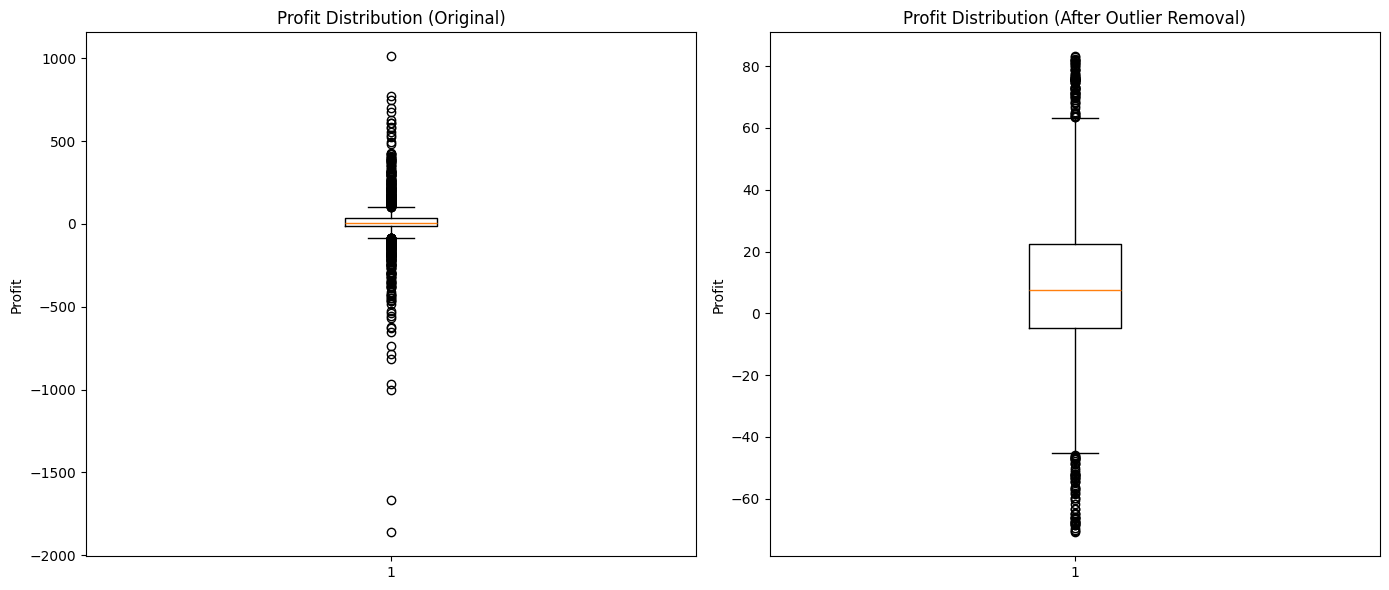

--------------------------------------------------
--- Member 2: Encoding Categorical Variables ---
Number of columns after encoding: 29
New encoded columns: ['Ship Mode_First Class' 'Ship Mode_Same Day' 'Ship Mode_Second Class'
 'Ship Mode_Standard Class' 'Segment_Consumer' 'Segment_Corporate'
 'Segment_Home Office' 'Region_Central' 'Region_East' 'Region_South'
 'Region_West' 'Category_Furniture']


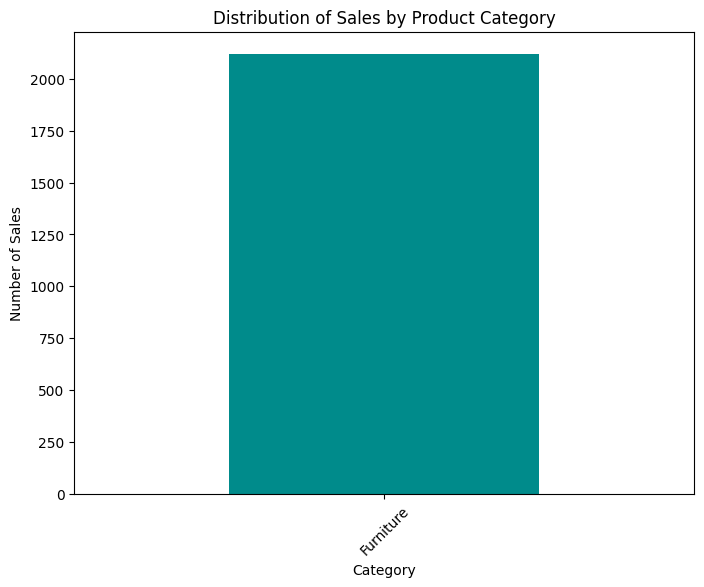

--------------------------------------------------
--- Member 3: Data Transformation (Yeo-Johnson) ---


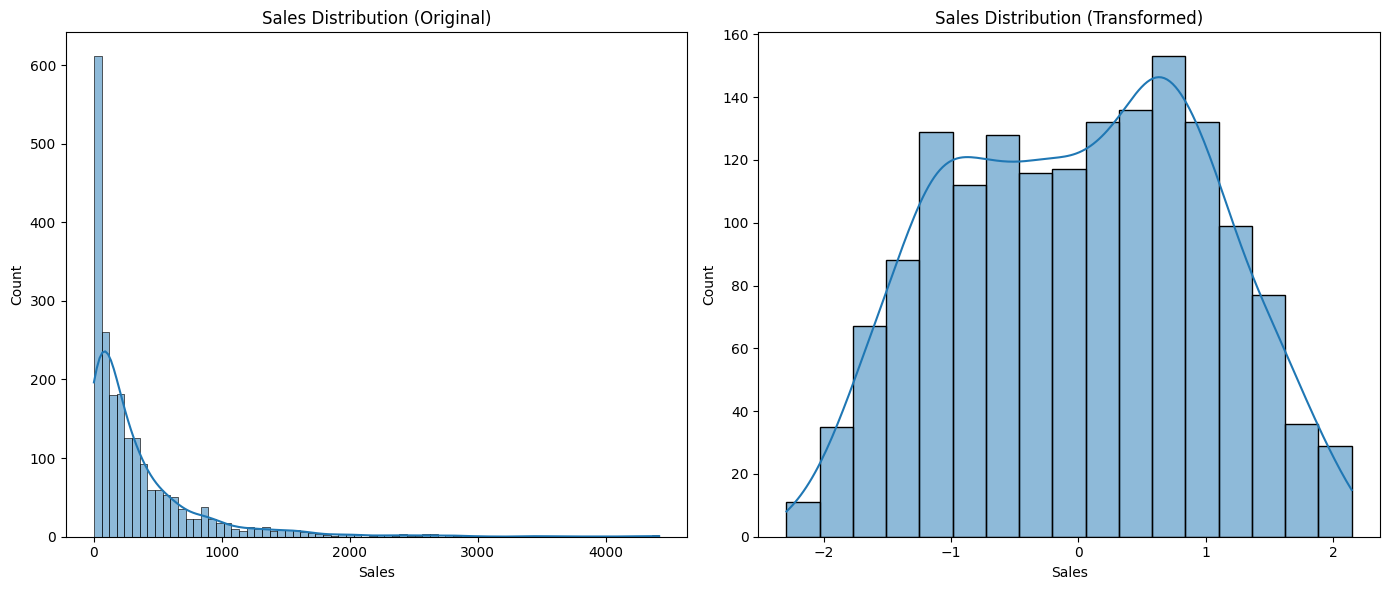

--------------------------------------------------
--- Member 4: Feature Engineering & Selection ---
Number of columns after feature selection: 17
Selected Features: ['Row ID', 'Postal Code', 'Quantity', 'Discount', 'Profit', 'Ship Mode_First Class', 'Ship Mode_Same Day', 'Ship Mode_Second Class', 'Ship Mode_Standard Class', 'Segment_Consumer', 'Segment_Corporate', 'Segment_Home Office', 'Region_Central', 'Region_East', 'Region_South', 'Region_West']


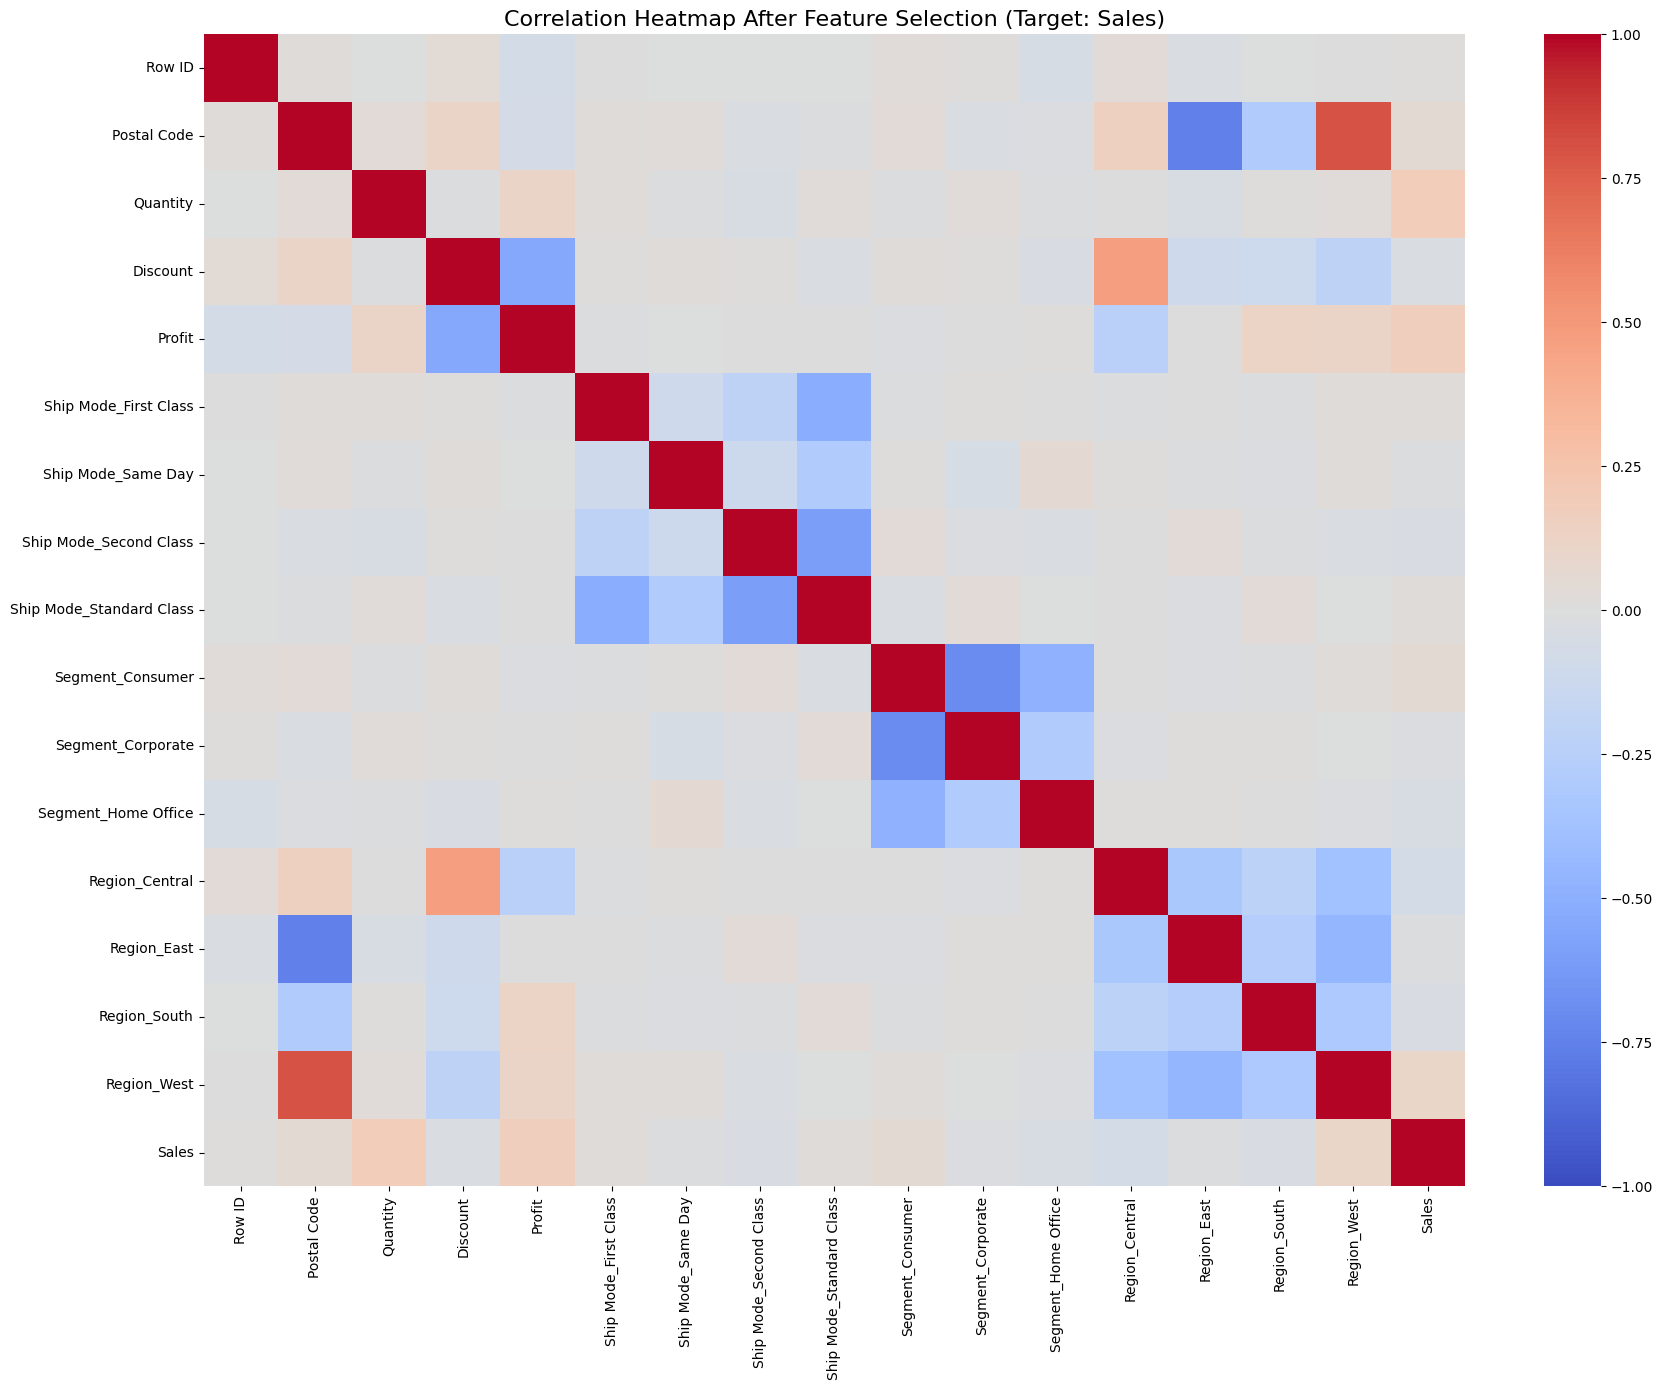

--------------------------------------------------
--- Member 5: Scaling Data (Normalization) ---
Sample of scaled data:
      Sales  Quantity  Discount    Profit
0  0.825404 -0.712379 -0.937112  1.184817
1 -0.528955  2.126119 -0.937112  0.169248
2 -0.249048 -0.712379  0.833765 -0.374448
3  0.186690 -0.144680  0.243472  0.218471
4  1.490792 -0.144680  0.951823 -1.911270


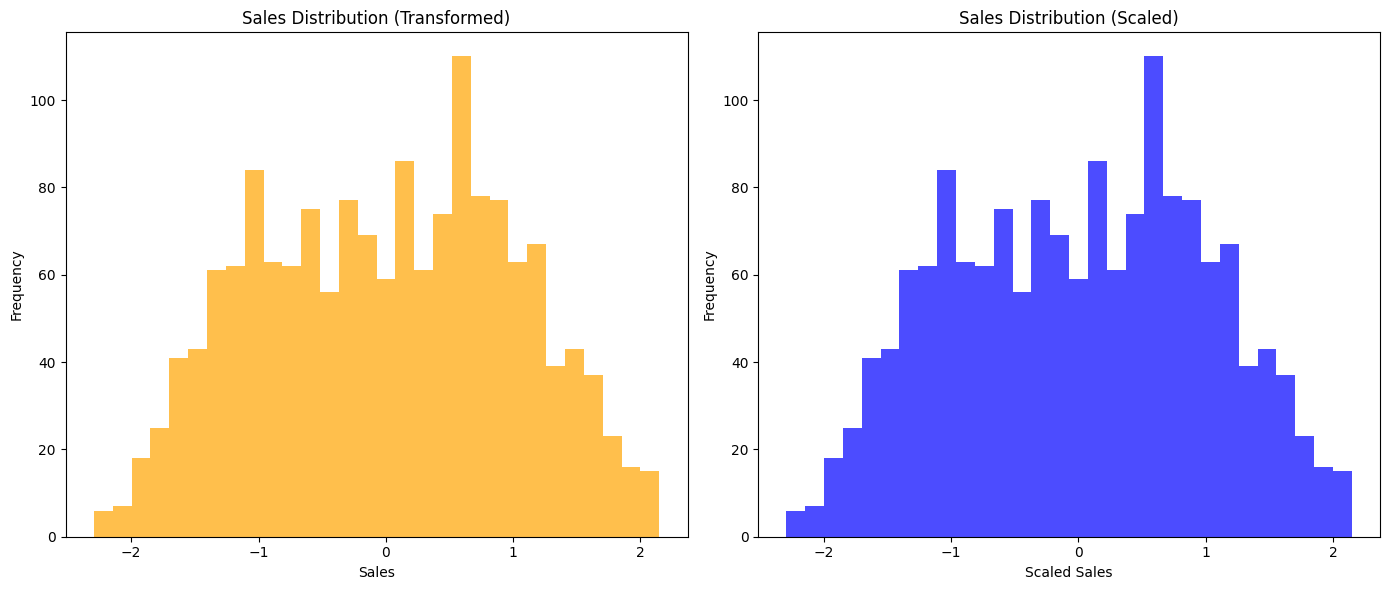

--------------------------------------------------
--- Member 6: Discretization / Binning ---
New 'Sales_Range' feature created:
      Sales    Sales_Range
0  0.825404  Above Average
1 -0.528955  Below Average
2 -0.249048        Average
3  0.186690        Average
4  1.490792           High

Distribution of the new 'Sales_Range' feature:
Sales_Range
Low              140
Below Average    407
Average          408
Above Average    469
High             173
Name: count, dtype: int64


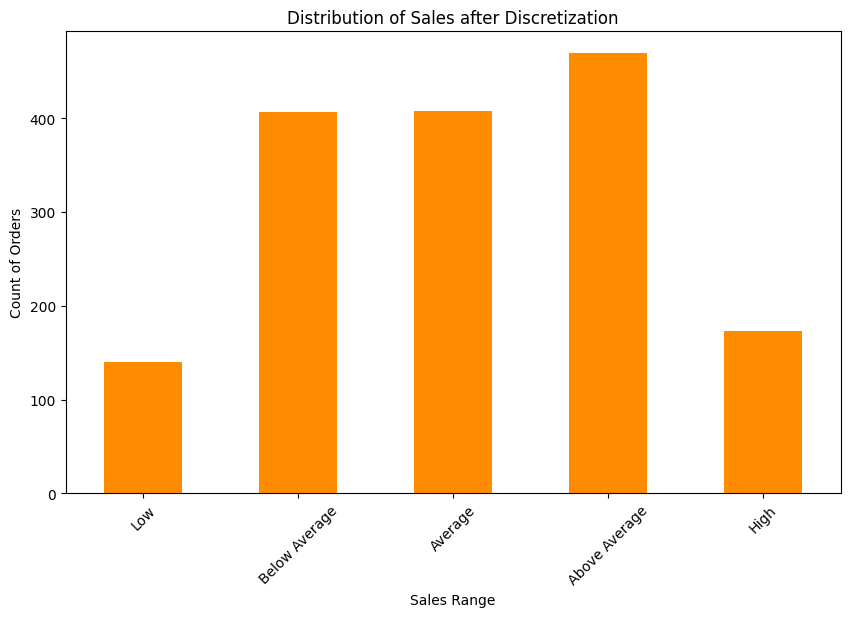

In [6]:
### Group Assignment: Complete Preprocessing & EDA Pipeline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold

# --- Step 1: Mount Google Drive and Load the Dataset ---
print("--- Step 1: Connecting to Google Drive and Loading Data ---")
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/stores_sales_forecasting.csv'

try:
    df = pd.read_csv(file_path, encoding='latin1')
    print("Dataset loaded successfully from Google Drive!")
except FileNotFoundError:
    print(f"ERROR: File not found at the specified path: {file_path}")
    print("Please verify the file name and path in Google Drive.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    exit()

# Initial data cleaning and conversion
df_cleaned = df.dropna().copy()
df_cleaned['Order Date'] = pd.to_datetime(df_cleaned['Order Date'])
df_cleaned['Ship Date'] = pd.to_datetime(df_cleaned['Ship Date'])
df_current = df_cleaned.copy()
print("-" * 50)


# --- Member 1: Outlier Removal ---
# Using the IQR method to remove outliers from key numerical columns
print("--- Member 1: Outlier Removal ---")
numerical_cols_outliers = ['Sales', 'Quantity', 'Discount', 'Profit']
for col in numerical_cols_outliers:
    Q1 = df_current[col].quantile(0.25)
    Q3 = df_current[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_current = df_current[(df_current[col] >= lower_bound) & (df_current[col] <= upper_bound)]

print(f"Number of rows after outlier removal: {len(df_current)}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].boxplot(df_cleaned['Profit'])
axes[0].set_title('Profit Distribution (Original)')
axes[0].set_ylabel('Profit')
axes[1].boxplot(df_current['Profit'])
axes[1].set_title('Profit Distribution (After Outlier Removal)')
axes[1].set_ylabel('Profit')
plt.tight_layout()
plt.show()
print("-" * 50)


# --- Member 2: Encoding Categorical Variables ---
# Using One-Hot Encoding to convert categorical features into numerical format
print("--- Member 2: Encoding Categorical Variables ---")
categorical_cols = ['Ship Mode', 'Segment', 'Region', 'Category']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_current_reset = df_current.reset_index(drop=True)
encoded_data = encoder.fit_transform(df_current_reset[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))
df_current = pd.concat([df_current_reset.drop(columns=categorical_cols, axis=1), encoded_df], axis=1)

print(f"Number of columns after encoding: {len(df_current.columns)}")
print("New encoded columns:", encoder.get_feature_names_out(categorical_cols))

# Visualization for Member 2
category_counts = df_cleaned['Category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='darkcyan')
plt.title('Distribution of Sales by Product Category')
plt.xlabel('Category')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)
plt.show()
print("-" * 50)


# --- Member 3: Data Transformation (Yeo-Johnson) ---
# Applying Yeo-Johnson transformation to 'Sales' and 'Profit' to reduce skewness and handle negative values
print("--- Member 3: Data Transformation (Yeo-Johnson) ---")
yeo_johnson_cols = ['Sales', 'Profit']
pt = PowerTransformer(method='yeo-johnson')
df_current[yeo_johnson_cols] = pt.fit_transform(df_current[yeo_johnson_cols])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(df_cleaned['Sales'], kde=True, ax=axes[0])
axes[0].set_title('Sales Distribution (Original)')
sns.histplot(df_current['Sales'], kde=True, ax=axes[1])
axes[1].set_title('Sales Distribution (Transformed)')
plt.tight_layout()
plt.show()
print("-" * 50)


# --- Member 4: Feature Engineering & Selection (from Untitled7.ipynb) ---
print("--- Member 4: Feature Engineering & Selection ---")

# Separate features and target
TARGET_COL = 'Sales'
y = df_current[TARGET_COL]
X = df_current.drop(columns=[TARGET_COL])

# Identify numerical and one-hot encoded columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
encoded_cols = X.select_dtypes(include=['bool', 'uint8']).columns # OneHotEncoder produces these dtypes

# Apply VarianceThreshold to numerical features only
selector = VarianceThreshold(threshold=0.01)
X_numerical = X[numerical_cols]
X_reduced_array = selector.fit_transform(X_numerical)
selected_numerical_features = X_numerical.columns[selector.get_support()]

# Create the new DataFrame with selected features and the target variable
df_selected_numerical = pd.DataFrame(X_reduced_array, columns=selected_numerical_features, index=X.index)
df_selected = pd.concat([df_selected_numerical, X[encoded_cols]], axis=1)
df_selected[TARGET_COL] = y
df_current = df_selected.copy()

print(f"Number of columns after feature selection: {len(df_current.columns)}")
print("Selected Features:", selected_numerical_features.tolist() + encoded_cols.tolist())

# Visualization for Feature Engineering - Correlation Heatmap
corr = df_current.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(corr, annot=False, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Heatmap After Feature Selection (Target: Sales)", fontsize=16)
plt.tight_layout()
plt.show()
print("-" * 50)


# --- Member 5: Scaling Data (Normalization) ---
# Using StandardScaler to normalize numerical features
print("--- Member 5: Scaling Data (Normalization) ---")
numerical_cols_to_scale = ['Sales', 'Quantity', 'Discount', 'Profit']
scaler = StandardScaler()
df_scaled = df_current.copy()
df_scaled[numerical_cols_to_scale] = scaler.fit_transform(df_scaled[numerical_cols_to_scale])

print("Sample of scaled data:")
print(df_scaled[numerical_cols_to_scale].head())

# Visualization for Scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].hist(df_current['Sales'], bins=30, color='orange', alpha=0.7)
axes[0].set_title('Sales Distribution (Transformed)')
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')
axes[1].hist(df_scaled['Sales'], bins=30, color='blue', alpha=0.7)
axes[1].set_title('Sales Distribution (Scaled)')
axes[1].set_xlabel('Scaled Sales')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
print("-" * 50)


# --- Member 6: Discretization / Binning ---
# Using pd.cut() to bin the 'Sales' column
print("--- Member 6: Discretization / Binning ---")
df_binned = df_current.copy()
num_bins = 5
bin_labels = ['Low', 'Below Average', 'Average', 'Above Average', 'High']
df_binned['Sales_Range'] = pd.cut(df_binned['Sales'], bins=num_bins, labels=bin_labels)

print("New 'Sales_Range' feature created:")
print(df_binned[['Sales', 'Sales_Range']].head())
print("\nDistribution of the new 'Sales_Range' feature:")
print(df_binned['Sales_Range'].value_counts().sort_index())

# Visualization for Discretization
plt.figure(figsize=(10, 6))
df_binned['Sales_Range'].value_counts().sort_index().plot(kind='bar', color='darkorange')
plt.title('Distribution of Sales after Discretization')
plt.xlabel('Sales Range')
plt.ylabel('Count of Orders')
plt.xticks(rotation=45)
plt.show()